In [1]:
import dask
from dask.diagnostics import ProgressBar
from dask.distributed import Client

In [4]:
import scipy as sp
import scipy.io
import os
import numpy as np
import pandas as pd
import glob
import csv
import random as rand
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as plt
from matplotlib import patches
import random as rand
from ipywidgets import *
import colorlover as cl
from scipy import stats
import importlib
import sys
sys.path.append('../')
from utils import utils, zscores
from tqdm.notebook import tqdm
import h5py
import matplotlib as mpl
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16)
mpl.rc('axes', labelsize=16)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [5]:
os.chdir(r'C:\Users\Eric\Documents\09-12-2021\Data\crossmodal_only')

In [6]:
log = sp.io.loadmat('S1_microstim_log.mat')
cols = ['mouse_name', 'date', 'block_type', 'stim_type', 'trial_num','touch_stim', 'vis_stim', 'resp']
beh_log = pd.DataFrame(log['all_session_beh'], columns = cols).applymap(lambda x: x[0])
beh_log[['trial_num','resp']] = beh_log[['trial_num','resp']].applymap(lambda x: x[0])

beh_log['mouse_name'] = beh_log['mouse_name'].apply(lambda x: x[-6:])
beh_log = beh_log[~(beh_log['block_type'] == 'Change')]
beh_log.head()

,mouse_name,date,block_type,stim_type,trial_num,touch_stim,vis_stim,resp
0,EF0147,12-04-18,Visual,Stim_Vis_NoCue,1,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,1
1,EF0147,12-04-18,Visual,Stim_Som_NoCue,2,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,1
2,EF0147,12-04-18,Visual,Stim_Som_NoCue,3,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,2
3,EF0147,12-04-18,Visual,Stim_Vis_NoCue,4,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,3
4,EF0147,12-04-18,Visual,Stim_Vis_NoCue,5,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,2


In [7]:
# logs = []
# for mouse in beh_log['mouse_name'].unique():
#     mouse_dates = mice.loc[mice['mouse_name'] == mouse, 'date'].values
#     for f in glob.glob(f'Log_{mouse}*'):
#         log = sp.io.loadmat(f)['log']
#         if np.isin(log[0][1][0], mouse_dates):
#             logs.append(pd.DataFrame(log))

# raw_logs = pd.concat(logs)
# raw_logs = raw_logs.applymap(lambda x: np.squeeze(x))
# raw_logs.iloc[:, 7:] = (raw_logs.iloc[:, 7:]
#                         .applymap(lambda x: np.squeeze(x)))

In [8]:
# cols = [
#     'mouse_name',
#     'date',
#     'block_type',
#     'stim_type',
#     'stim_intes',
#     'stim_intes2',
#     'resp',
#     'trial_num',
#     'trial_start',
#     'stim_onset',
#     'stim_offset',
#     'licks_right',
#     'licks_left',
#     'units'
# ]

# raw_logs.columns = cols
# raw_logs = raw_logs.drop(['stim_intes', 'stim_intes2', 'units'], axis = 1)

In [9]:
# raw_logs.loc[:, ['licks_right', 'licks_left']] =  raw_logs[['licks_right', 'licks_left']].applymap(lambda x: x.tolist() if isinstance(x, np.ndarray) else [x])

In [10]:
# all_licks = []
# for _, licks in raw_logs[['licks_right', 'licks_left']].iterrows():
#     trial_licks = []
#     if len(licks['licks_right']) > 0:
#         trial_licks.extend(licks['licks_right'])
    
#     if len(licks['licks_left']) > 0:
#         trial_licks.extend(licks['licks_left'])
        
#     all_licks.append(np.sort(trial_licks))

# raw_logs['all_licks'] = all_licks

In [11]:
# aligned_licks = []
# for _, trial in raw_logs.iterrows():
#     if (len(trial['all_licks']) > 0) & isinstance(trial['stim_onset'], float):
#         aligned_licks.append(np.array(trial['all_licks']) - trial['stim_onset'])
#     else:
#         aligned_licks.append(np.nan)
        
# raw_logs['aligned_licks'] = aligned_licks
# raw_logs['aligned_licks'] = raw_logs['aligned_licks'].apply(lambda x: x[x>=0.1] if x is not np.nan else np.nan)

In [12]:
beh_log['correct'] = 0
match = (((beh_log['block_type'] == 'Whisker') & (beh_log['stim_type'].str.contains('Som|catch', regex = True))) | 
         ((beh_log['block_type'] == 'Visual') & (beh_log['stim_type'].str.contains('Vis'))))

correct = (match & beh_log['resp'].isin([1,2])) | (~match & (beh_log['resp'] == 0))

beh_log.loc[correct, 'correct'] = 1

In [13]:
beh_log = beh_log.groupby(['mouse_name', 'date']).apply(lambda x: x.sort_values(['trial_num'])).reset_index(drop=True)

In [14]:
sham = {'EF0147': ['12-14-18', '12-15-18', '12-17-18'], 
        'EF0148':['12-10-18', '12-17-18'], 
        'EF0149': ['12-11-18', '12-14-18', '12-16-18'],
        'EF0150': ['12-17-18', '12-19-18', '12-20-18', '12-21-18']}

stim = {'EF0147': ['12-11-18', '12-13-18', '12-16-18'], 
        'EF0148':['12-11-18', '12-14-18', '12-16-18'], 
        'EF0149': ['12-13-18', '12-15-18', '12-17-18'],
        'EF0150': ['12-13-18', '12-18-18', '12-28-18']}


In [15]:
sham_days = pd.concat([pd.DataFrame({mouse:dates}).stack() for mouse, dates in sham.items()])
stim_days = pd.concat([pd.DataFrame({mouse:dates}).stack() for mouse, dates in stim.items()])
sham_days = sham_days.reset_index().drop('level_0', axis = 1)
stim_days = stim_days.reset_index().drop('level_0', axis = 1)

sham_days['session_type'] = 'sham'
stim_days['session_type'] = 'stim'

test_days = pd.concat([stim_days,sham_days])
test_days = test_days.rename(columns = {'level_1': 'mouse_name', 0:'date'})
beh_log_test = beh_log.merge(test_days, on = ['mouse_name', 'date'])

In [16]:
beh_log_test['session_type'].unique()

array(['stim', 'sham'], dtype=object)

In [17]:
correct_resp = beh_log_test[(beh_log_test['resp'] > 0) & (beh_log_test['correct'] == 1)]

In [18]:
vis = correct_resp.loc[correct_resp['stim_type'] == 'Stim_Vis_NoCue']
vis

,mouse_name,date,block_type,stim_type,trial_num,touch_stim,vis_stim,resp,correct,session_type
89,EF0147,12-11-18,Visual,Stim_Vis_NoCue,90,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,1,1,stim
97,EF0147,12-11-18,Visual,Stim_Vis_NoCue,99,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,2,1,stim
99,EF0147,12-11-18,Visual,Stim_Vis_NoCue,101,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,2,1,stim
100,EF0147,12-11-18,Visual,Stim_Vis_NoCue,102,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,2,1,stim
102,EF0147,12-11-18,Visual,Stim_Vis_NoCue,104,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,2,1,stim
...,...,...,...,...,...,...,...,...,...,...
7542,EF0150,12-28-18,Visual,Stim_Vis_NoCue,322,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,2,1,stim
7546,EF0150,12-28-18,Visual,Stim_Vis_NoCue,326,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,2,1,stim
7553,EF0150,12-28-18,Visual,Stim_Vis_NoCue,333,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,2,1,stim
7555,EF0150,12-28-18,Visual,Stim_Vis_NoCue,335,SineAmp0p875Freq20Cyc3,Amp0p5Dur0p150,2,1,stim


## Get into the raw data

In [19]:
import glob

In [20]:
filenames = glob.glob("C:/Users/Eric/Documents/09-12-2021/DATA/Crossmodal_only/s1_activation_raw_data/*/cat_session*")

In [21]:
def get_trial_lick_times(session, trialNum):
    trial_inds = [session['timeTrialNumber']==trialNum]
    within_time = session['timeWithinTrial'][trial_inds]
    raw_time = np.ravel(session['Time'][trial_inds])
    stimOnsetArray = np.ravel(session['stimOnset'])[trial_inds]
    stimOnset = within_time[stimOnsetArray==1]
    stimOffset = within_time[stimOnsetArray==2]
    optiStim = within_time[np.isin(raw_time, session['optoStimOnsetTime'])]
    rLickTimes = within_time[np.isin(raw_time, session['rLickTimes'])]
    lLickTimes = within_time[np.isin(raw_time, session['lLickTimes'])]
    lLickTimes = within_time[np.isin(raw_time, session['lLickTimes'])]
    
    if (MouseName == 'EF0149') & (date =='12-17-18'):
        #this data was preprocessed using wrong script - manually modify data:
        trialNum = trialNum-2
        
    return {'trial_num': trialNum, 
            'stim_onset': stimOnset, 
            'stim_offset': stimOffset, 
            'rLickTimes': rLickTimes,
            'lLickTimes': lLickTimes,
            'optoStim': optiStim
           }

In [22]:
sessions = []

for fn in tqdm(filenames):
    try:
        session = h5py.File(fn, 'r')['session']
    except:
        session = h5py.File(fn, 'r')['s']

    MouseName = ''.join([chr(v[0]) for v in session['MouseName'][:]])
    date = ''.join([chr(v[0]) for v in session['SessionDate'][:]])
    
    if (MouseName == 'EF0149') & (date =='12-17-18'): 
        #this data was preprocessed using wrong script - manually extract stimOnsets from raw traces:
        stimOnset = np.zeros(session['adcSignal'][:,0].shape)
        crossThresh = np.where((session['adcSignal'][:,0]>0.02) | (session['adcSignal'][:,1]>0.15))[0]
        CTdiff = np.diff(crossThresh);
        stimOnsetInds = np.concatenate([[crossThresh[0]], crossThresh[np.where(CTdiff>25000)[0]]])
        stimOnset[stimOnsetInds] = 1;
    else:
        stimOnset = session['stimOnset'][:]

    session_dict ={
        'timeTrialNumber': session['timeTrialNumber'][0],
        'timeWithinTrial': session['timeWithinTrial'][0],
        'Time': session['Time'][:],
        'stimOnset': stimOnset,
        'rLickTimes': session['rLickTimes'][:],
        'lLickTimes': session['lLickTimes'][:],
        'optoStimOnsetTime': session['optoStimOnsetTime'][:]
    }
    
    trialNums = np.unique(session['trialNums'][:])
    trial_times = []

    for i in tqdm(trialNums):
        trial_times.append(get_trial_lick_times(session_dict, i))
        
    session_df = pd.DataFrame(trial_times)
    session_df['mouse_name'] = MouseName
    session_df['date'] = date

    sessions.append(session_df)

    

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/265 [00:00<?, ?it/s]

C:\Users\Eric\AppData\Local\Temp/ipykernel_624/1111256542.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  within_time = session['timeWithinTrial'][trial_inds]
C:\Users\Eric\AppData\Local\Temp/ipykernel_624/1111256542.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  raw_time = np.ravel(session['Time'][trial_inds])
C:\Users\Eric\AppData\Local\Temp/ipykernel_624/1111256542.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/290 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/377 [00:00<?, ?it/s]

  0%|          | 0/339 [00:00<?, ?it/s]

  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/455 [00:00<?, ?it/s]

In [23]:
df = pd.concat(sessions, axis = 0)

In [24]:
beh_log_test_times = beh_log_test.merge(df[['mouse_name','date', 'trial_num', 'optoStim', 'stim_onset', 'rLickTimes', 'lLickTimes']], on = ['mouse_name', 'date', 'trial_num'], how = 'inner')
beh_log_test_times = beh_log_test_times[~((beh_log_test_times['mouse_name'] == 'EF0150') & (beh_log_test_times['date'] == '12-28-18'))]
beh_log_stim = beh_log_test_times.loc[beh_log_test_times['session_type'] == 'stim']
beh_log_sham = beh_log_test_times.loc[beh_log_test_times['session_type'] == 'sham']

In [25]:
catchHit = beh_log_stim.loc[(beh_log_stim['stim_type'] == 'catch') & (beh_log_stim['block_type'] == 'Whisker') & (beh_log_stim['correct'] == 1)].copy()
catchFA = beh_log_stim.loc[(beh_log_stim['stim_type'] == 'catch') & (beh_log_stim['block_type'] == 'Visual') & (beh_log_stim['correct'] == 0)].copy()
catchFA_R = beh_log_stim.loc[(beh_log_stim['stim_type'] == 'catch') & (beh_log_stim['block_type'] == 'Visual') & (beh_log_stim['resp'] == 1)].copy()
catchFA_L = beh_log_stim.loc[(beh_log_stim['stim_type'] == 'catch') & (beh_log_stim['block_type'] == 'Visual') & (beh_log_stim['resp'] == 2)].copy()
catchFA['allLickTimes'] = catchFA.apply(lambda x: np.concatenate([x['rLickTimes'], x['lLickTimes']]), axis = 1)

tacHit = beh_log_stim.loc[(beh_log_stim['stim_type'] == 'Stim_Som_NoCue') & (beh_log_stim['block_type'] == 'Whisker') & (beh_log_stim['correct'] == 1)].copy()
visHit = beh_log_stim.loc[(beh_log_stim['stim_type'] == 'Stim_Vis_NoCue') & (beh_log_stim['block_type'] == 'Visual') & (beh_log_stim['correct'] == 1)].copy()

In [26]:
catchHit['optoStim'] = catchHit['optoStim'].apply(lambda x: x[0] if len(x)>0 else np.nan)
catchFA['optoStim'] = catchFA['optoStim'].apply(lambda x: x[0] if len(x)>0 else np.nan)
catchFA_R['optoStim'] = catchFA_R['optoStim'].apply(lambda x: x[0] if len(x)>0 else np.nan)
catchFA_L['optoStim'] = catchFA_L['optoStim'].apply(lambda x: x[0] if len(x)>0 else np.nan)

catchHit = catchHit.loc[~catchHit['optoStim'].isna()]
catchFA = catchFA.loc[~catchFA['optoStim'].isna()]

In [27]:
catchHit['rLickTimes'] = catchHit.apply(lambda x: x['rLickTimes'][x['rLickTimes']> x['optoStim']], axis = 1)
catchFA['allLickTimes'] = catchFA.apply(lambda x: x['allLickTimes'][x['allLickTimes']> x['optoStim']], axis = 1)

tacHit['rLickTimes'] = tacHit.apply(lambda x: x['rLickTimes'][x['rLickTimes']> x['stim_onset']], axis = 1)
visHit['lLickTimes'] = visHit.apply(lambda x: x['lLickTimes'][x['lLickTimes']> x['stim_onset']], axis = 1)

In [28]:
catchHit['RT'] = catchHit.apply(lambda x: x['rLickTimes'][0]- x['optoStim'] if len(x['rLickTimes'])>0 else np.nan, axis = 1)
catchFA['RT'] = catchFA.apply(lambda x: x['allLickTimes'][0]- x['optoStim'] if len(x['allLickTimes'])>0 else np.nan, axis = 1)

tacHit['RT'] = tacHit.apply(lambda x: x['rLickTimes'][0]- x['stim_onset'] if len(x['rLickTimes'])>0 else [np.nan], axis = 1)
visHit['RT'] = visHit.apply(lambda x: x['lLickTimes'][0]- x['stim_onset'] if len(x['lLickTimes'])>0 else [np.nan], axis = 1)

In [29]:
tacHit['RT'] = tacHit['RT'].apply(lambda x: x[0])
visHit['RT'] = visHit['RT'].apply(lambda x: x[0])

In [30]:
catchHit['RT'].median(), catchFA['RT'].median(), catchFA_R['RT'].median(), catchFA_L['RT'].median(), tacHit['RT'].median(), visHit['RT'].median()

KeyError: 'RT'

In [31]:
catchHit_medians = catchHit.groupby(['mouse_name', 'date']).median().reset_index()['RT']
catchFA_medians = catchFA.groupby(['mouse_name', 'date']).median().reset_index()['RT']

tacHit_medians = tacHit.groupby(['mouse_name', 'date']).median().reset_index()['RT']
visHit_medians = visHit.groupby(['mouse_name', 'date']).median().reset_index()['RT']

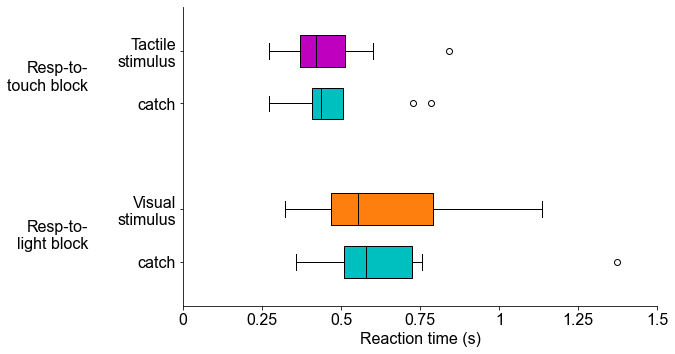

In [35]:
import matplotlib.pylab as plt
plt.close('all')
fig1a_1 = plt.figure(figsize = (8.5,5.5))
ax = fig1a_1.add_subplot(111)

colors = [ 'c', 'C1', 'c', 'm']
titles = ['catch',  'Visual\nstimulus', 'catch', 'Tactile\nstimulus']

bplot = ax.boxplot([catchFA_medians,  visHit_medians, catchHit_medians, tacHit_medians], 
                   labels = titles, vert = False, patch_artist=True, showfliers = True, positions = [0.3,.9,2.1,2.7])

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

plt.setp(bplot['medians'], color='k')

ax.set_clip_on(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,1.5])
ax.set_ylim([-.2,3.2])
ax.text(-.3, 2.25, 'Resp-to-\ntouch block', ha = 'right')
ax.text(-.3, 0.45, 'Resp-to-\nlight block', ha = 'right')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5])
ax.set_xticklabels(['0', '0.25', '0.5', '0.75', '1', '1.25', '1.5'])


ax.set_xlabel('Reaction time (s)')  
fig = plt.gcf()

os.chdir('C:\\Users\\Eric\\Documents\\09-12-2021\\crossmodal\\Figure7')
# fig.savefig('S1-microstim_rt.pdf',format='pdf', dpi=900, transparent = True)

In [ ]:
os.getcwd()

In [ ]:
fig1a_1

In [ ]:
rt_data

In [37]:
catchHit_medians

0    0.442500
1    0.368600
2    0.499133
3    0.506317
4    0.405783
5    0.784800
6    0.413583
7    0.728450
8    0.432333
9    0.270767
Name: RT, dtype: float64

In [40]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
index = np.concatenate([['catchTac']*len(catchHit_medians),['touch']*len(tacHit_medians),['catchVis']*len(catchFA_medians),['visual']*len(visHit_medians)])
rt_data = (np.concatenate([catchHit_medians,tacHit_medians,catchFA_medians,visHit_medians]))

print(pairwise_tukeyhsd(rt_data, index))

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
catchTac catchVis   0.1635 0.3782 -0.1076 0.4347  False
catchTac    touch   -0.025 0.9945 -0.2962 0.2461  False
catchTac   visual   0.1598 0.3984 -0.1113 0.4309  False
catchVis    touch  -0.1886 0.2575 -0.4597 0.0826  False
catchVis   visual  -0.0037    1.0 -0.2749 0.2674  False
   touch   visual   0.1848 0.2737 -0.0863  0.456  False
-------------------------------------------------------
